In [13]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [14]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each task subset


    #train multiple classifiers
    for T in tasks:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            task_inds = Data.Task.iloc[test_index]==T[0]
            for Ti in T[1::]:
                task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
            test_index = test_index[task_inds]
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)

            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)

            s+=1

        #group results for each model
        groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

In [15]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [29]:
Data = pd.read_hdf('/Volumes/RTO/CIS-PD Study/Clinic WACC features/WatchClinicFeatHP.hdf',index_col=0)

In [30]:
Dataorig = Data.copy()

In [31]:
Data.head()

,Subject,Visit,Task,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,rangeX,rangeY,...,Dom_freq,Pdom_rel,PSD_mean,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur
0,1024,2 Weeks: Time 0,Stndg,NaN,0.0,0.000904,0.000843,0.000814,0.089509,0.092758,...,0.199579,0.213966,0.000006,0.000012,3.629858,14.701851,0.000022,0.008585,-0.006953,1.693808
1,1024,2 Weeks: Time 0,Stndg,NaN,0.0,0.000662,0.000603,0.000434,0.052990,0.051516,...,0.798164,0.134220,0.000003,0.000003,3.060827,13.726792,-0.000003,0.006465,0.272207,-0.072471
2,1024,2 Weeks: Time 0,Stndg,NaN,0.0,0.002186,0.003977,0.002024,0.278312,0.530512,...,0.200379,0.466985,0.000140,0.000493,5.382153,29.946569,0.000710,0.021569,0.600199,11.047957
3,1024,2 Weeks: Time 0,Stndg,NaN,0.0,0.002516,0.004254,0.002359,0.278312,0.530512,...,0.200379,0.300496,0.000720,0.001792,4.336647,19.648170,-0.000006,0.023906,-0.015128,9.011930
4,1024,2 Weeks: Time 0,Stndg,NaN,0.0,0.001374,0.001624,0.001284,0.217327,0.257278,...,0.000000,0.438906,0.000011,0.000036,5.344946,28.520897,-0.000828,0.011961,-4.077816,37.831825


In [37]:
np.sort(Data.Subject.unique())

array([1004, 1016, 1018, 1019, 1024, 1029, 1030, 1032, 1038, 1044, 1046,
       1049, 1051])

In [32]:
len(Data)

14055

In [38]:
len(Data.Subject.unique())

13

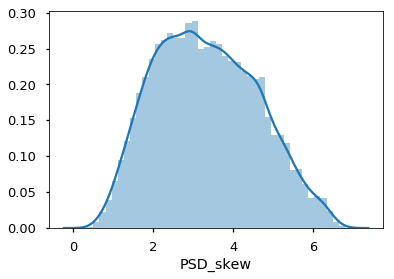

In [21]:
sns.distplot(Data.PSD_skew)

In [22]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 7022/12197 = 0.58
Training Random Forest

Subj/Visit 0, prec=0.641, rec=0.670, Spec=0.357, auroc_train=1.000, auroc=0.527

Subj/Visit 1, prec=0.388, rec=0.599, Spec=0.584, auroc_train=1.000, auroc=0.617
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=1.000, rec=0.495, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 3, prec=0.506, rec=0.867, Spec=0.578, auroc_train=1.000, auroc=0.799

Subj/Visit 4, prec=0.688, rec=0.514, Spec=0.473, auroc_train=1.000, auroc=0.497

Subj/Visit 5, prec=0.931, rec=0.829, Spec=0.662, auroc_train=1.000, auroc=0.776

Subj/Visit 6, prec=0.923, rec=0.720, Spec=0.688, auroc_train=1.000, auroc=0.734

Subj/Visit 7, prec=0.641, rec=0.865, Spec=0.290, auroc_train=1.000, auroc=0.593

Subj/Visit 8, prec=0.574, rec=0.849, Spec=0.246, auroc_train=1.000, auroc=0.664
only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=1.000, rec=0.640, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 10, prec=0.714, rec=0.834, Spec=0.494, auroc_train=1.000, auroc=0.729

Subj/Visit 11, prec=0.686, rec=0.651, Spec=0.574, auroc_train=1.000, auroc=0.640

Subj/Visit 12, prec=0.647, rec=0.930, Spec=0.333, auroc_train=1.000, auroc=0.634

Subj/Visit 13, prec=0.819, rec=0.749, Spec=0.416, auroc_train=1.000, auroc=0.604

Subj/Visit 14, prec=0.073, rec=0.763, Spec=0.266, auroc_train=1.000, auroc=0.525
only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=1.000, rec=0.585, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=1.000, rec=0.771, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 17, prec=0.075, rec=0.918, Spec=0.328, auroc_train=1.000, auroc=0.721

Subj/Visit 18, prec=0.558, rec=0.493, Spec=0.552, auroc_train=1.000, auroc=0.530
only 1 class in test data - cannot compute roc curve

Subj/Visit 19, prec=1.000, rec=1.000, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 20, prec=0.924, rec=0.519, Spec=0.389, auroc_train=1.000, auroc=0.429

Subj/Visit 21, prec=0.382, rec=0.766, Spec=0.379, auroc_train=1.000, auroc=0.676
f1_test=0.658+/-0.205, prec=0.690+/-0.276, rec=0.728+/-0.148, auprc=0.721+/-0.258, auroc=0.629+/-0.101
Elapsed time = 1.179 min


In [23]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4617/16224 = 0.28
Training Random Forest

Subj/Visit 0, prec=0.674, rec=0.288, Spec=0.876, auroc_train=1.000, auroc=0.669

Subj/Visit 1, prec=0.224, rec=0.516, Spec=0.823, auroc_train=1.000, auroc=0.698

Subj/Visit 2, prec=1.000, rec=0.027, Spec=1.000, auroc_train=1.000, auroc=0.377

Subj/Visit 3, prec=0.238, rec=0.294, Spec=0.897, auroc_train=1.000, auroc=0.711

Subj/Visit 4, prec=0.206, rec=0.031, Spec=0.957, auroc_train=1.000, auroc=0.400

Subj/Visit 5, prec=0.697, rec=0.160, Spec=0.959, auroc_train=1.000, auroc=0.719

Subj/Visit 6, prec=0.607, rec=0.270, Spec=0.966, auroc_train=1.000, auroc=0.848

Subj/Visit 7, prec=0.364, rec=0.369, Spec=0.956, auroc_train=1.000, auroc=0.757

Subj/Visit 8, prec=0.419, rec=0.182, Spec=0.688, auroc_train=1.000, auroc=0.386

Subj/Visit 9, prec=0.964, rec=0.300, Spec=0.987, auroc_train=1.000, auroc=0.798

Subj/Visit 10, prec=0.623, rec=0.354, Spec=0.891, auroc_train=1.000, auroc=0.723

Subj/Visit 11, prec=0.651, rec=0.407, Spec=0.823, au

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.476, rec=0.109, Spec=0.861, auroc_train=1.000, auroc=0.413


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 17, prec=0.000, rec=0.000, Spec=0.898, auroc_train=1.000, auroc=nan

Subj/Visit 18, prec=0.268, rec=0.094, Spec=0.815, auroc_train=1.000, auroc=0.301
only 1 class in test data - cannot compute roc curve

Subj/Visit 19, prec=1.000, rec=0.950, Spec=nan, auroc_train=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 20, prec=0.946, rec=0.543, Spec=0.892, auroc_train=1.000, auroc=0.856

Subj/Visit 21, prec=0.000, rec=0.000, Spec=0.924, auroc_train=1.000, auroc=0.538
f1_test=0.335+/-0.246, prec=0.516+/-0.328, rec=0.295+/-0.239, auprc=0.531+/-0.268, auroc=0.667+/-0.199
Elapsed time = 1.490 min


In [26]:
res_group['Random Forest']['auroc']

[0.5163760759214302,
 0.62827160897729517,
 nan,
 0.87037037037037046,
 0.52470142513046969,
 0.77142295912640513,
 0.72765957446808527,
 0.55447915606661924,
 0.62216483269705813,
 nan,
 0.74623082742967195,
 0.66430196844029399,
 0.63106416275430366,
 0.63604357298474945,
 0.46441548269184735,
 nan,
 nan,
 0.74493520035751526,
 0.60562792470687199,
 nan,
 0.40323539200304281,
 0.6990026632636076]